This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for text

## Natural-language processing: The bird's eye view

---








1.   Why it is called Natural Language?




**Some tasks of NLP,**


1.   What's the topic of the text? (Text Classification)
2.   Does this text contain abuse? (Content Filtering)
3.   Does the text sound positive or negative (Sentiment Analysis)
4.   Next word in the sentence (Language Modeling)
5.   How would you say this in Urdu (Language Translation)
6.   How would you summerize this article in one paragraph (summerization)



## Preparing text data

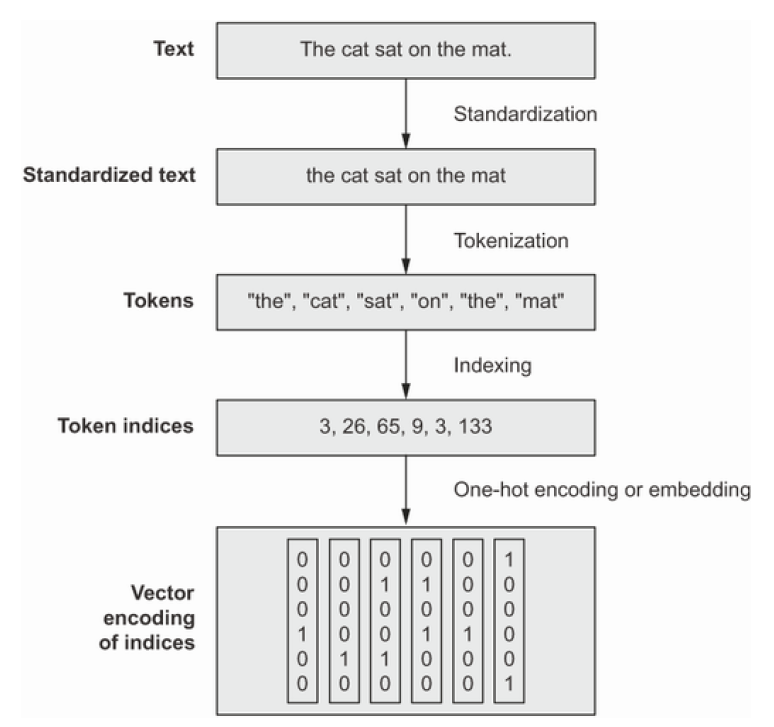

### Text standardization

### Text splitting (tokenization)

### Vocabulary indexing

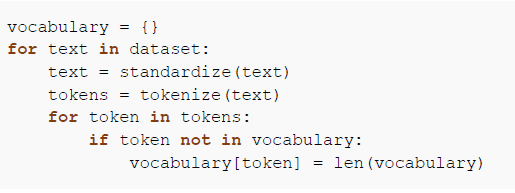

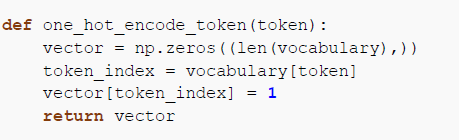

### Using the TextVectorization layer

In [ ]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1} #Unknown Word or Token
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)



In [ ]:
vectorizer = Vectorizer()
dataset = [
    "This is a good class.",
    "They all are good.",
    "They alway perform good.",
]
#:0, UNK:1, this:2, is:3, a:4, good:5, class:6, they:7, all:8, are:9, always:10, perform:11
vectorizer.make_vocabulary(dataset)

In [ ]:
vectorizer.vocabulary

{'': 0,
 '[UNK]': 1,
 'this': 2,
 'is': 3,
 'a': 4,
 'good': 5,
 'class': 6,
 'they': 7,
 'all': 8,
 'are': 9,
 'alway': 10,
 'perform': 11}

In [ ]:
test_sentence = "This is a good apple"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 4, 5, 1]


In [ ]:
vectorizer.vocabulary

{'': 0,
 '[UNK]': 1,
 'this': 2,
 'is': 3,
 'a': 4,
 'good': 5,
 'class': 6,
 'they': 7,
 'all': 8,
 'are': 9,
 'alway': 10,
 'perform': 11}

In [ ]:
decoded_sentence = vectorizer.decode(encoded_sentence)
print(decoded_sentence)

this is a good [UNK]


**Keras TextVectorization**
By default perform,


*   convert to lower case and remove punctuation
*   Split on whitespace
*   Provides custom functions for standardization and tokenization



In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int",
)

In [ ]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

In [ ]:
dataset = [
    "I write, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)

**Displaying the vocabulary**

In [ ]:
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'write',
 'then',
 'rewrite',
 'poppy',
 'i',
 'erase',
 'blooms',
 'and',
 'again',
 'a']

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([ 6  2  4  9  1  4 10], shape=(7,), dtype=int64)


In [ ]:
print(vocabulary)

['', '[UNK]', 'write', 'then', 'rewrite', 'poppy', 'i', 'erase', 'blooms', 'and', 'again', 'a']


In [ ]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


In [ ]:
inverse_vocab

{0: '',
 1: '[UNK]',
 2: 'write',
 3: 'then',
 4: 'rewrite',
 5: 'poppy',
 6: 'i',
 7: 'erase',
 8: 'blooms',
 9: 'and',
 10: 'again',
 11: 'a'}

## Two approaches for representing groups of words: Sets and sequences

### Preparing the IMDB movie reviews data

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  6121k      0  0:00:13  0:00:13 --:--:-- 13.3M


In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [2]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

In [ ]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

**Displaying the shapes and dtypes of the first batch**

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'Think of this film as a Saturday morning live-action program from ages ago. Even the small tykes will find this one hard to please because it runs like molasses! I can\'t fully understand how god awful it is to make something too typical and uninteresting, especially in the costume department! Too many warrior-wizard movies out there have used the same old plotline numerous times over, but this is mighty scarce considering its appeal to the little darlings. And who in the world would\'ve let a topless mermaid be cast in the first place? I thought this was a "family" movie! MST3K, here\'s another fine gem for your 1999 TV season!', shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


### Processing words as a set: The bag-of-words approach

#### Single words (unigrams) with binary encoding

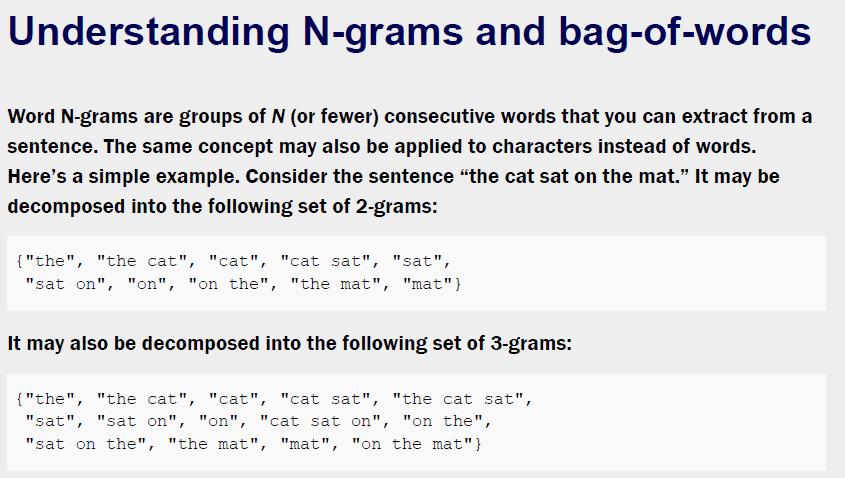

**Preprocessing our datasets with a `TextVectorization` layer**

In [ ]:
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
len(text_vectorization.get_vocabulary())

20000

In [ ]:
text_vectorization.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'but',
 'movie',
 'film',
 'on',
 'not',
 'you',
 'his',
 'are',
 'have',
 'he',
 'be',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'from',
 'who',
 'so',
 'like',
 'her',
 'or',
 'just',
 'about',
 'has',
 'if',
 'out',
 'some',
 'there',
 'what',
 'good',
 'when',
 'more',
 'very',
 'she',
 'even',
 'my',
 'no',
 'up',
 'would',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'we',
 'than',
 'much',
 'well',
 'been',
 'get',
 'into',
 'will',
 'also',
 'because',
 'great',
 'bad',
 'other',
 'people',
 'do',
 'how',
 'first',
 'most',
 'him',
 'dont',
 'made',
 'then',
 'movies',
 'make',
 'could',
 'films',
 'them',
 'any',
 'way',
 'after',
 'too',
 'think',
 'characters',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'where',
 'best',
 'love',


**Inspecting the output of our binary unigram dataset**

In [ ]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


**Our model-building utility**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

**Training and testing the binary unigram model**

In [ ]:
model = get_model()
model.summary()
#callbacks = [
#    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
#                                    save_best_only=True)
#]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10)
#model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.4037 - accuracy: 0.8291 - val_loss: 0.2944 - val_accuracy: 0.8818
Epoch 2/10
62

#### Bigrams with binary encoding

**Configuring the `TextVectorization` layer to return bigrams**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

**Training and testing the binary bigram model**

In [ ]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 10s 16ms/step - loss: 0.3924 - accuracy: 0.8354 - val_loss: 0.2863 - val_accuracy: 0.8928
Epoch 2/10
625/625 [=====================

In [ ]:
text_vectorization.get_vocabulary()

['[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'of the',
 'film',
 'on',
 'not',
 'you',
 'are',
 'his',
 'have',
 'he',
 'be',
 'one',
 'in the',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'from',
 'who',
 'so',
 'like',
 'her',
 'just',
 'or',
 'about',
 'has',
 'if',
 'out',
 'some',
 'there',
 'this movie',
 'what',
 'good',
 'when',
 'very',
 'more',
 'and the',
 'is a',
 'she',
 'even',
 'my',
 'the film',
 'up',
 'no',
 'would',
 'to the',
 'only',
 'time',
 'which',
 'really',
 'to be',
 'story',
 'their',
 'see',
 'were',
 'had',
 'can',
 'the movie',
 'me',
 'this film',
 'it is',
 'we',
 'than',
 'much',
 'this is',
 'well',
 'been',
 'get',
 'into',
 'also',
 'will',
 'people',
 'because',
 'do',
 'bad',
 'great',
 'how',
 'other',
 'first',
 'on the',
 'in a',
 'most',
 'him',
 'dont',
 'it was',
 'one of',
 'made',
 'then',
 'for the',
 'with the',
 'movies',
 'of a',

In [ ]:
dataset2 = [
    "I write, rewrite",
    "Erase again, and then a a a a ",
    "A poppy blooms.I I I and again and then write and write rewrite",
]
text_vectorization.adapt(dataset2)

In [ ]:
text_vectorization.get_vocabulary()

['[UNK]',
 'a',
 'and',
 'write',
 'i',
 'a a',
 'write rewrite',
 'then',
 'rewrite',
 'and then',
 'again and',
 'again',
 'write and',
 'then write',
 'then a',
 'poppy bloomsi',
 'poppy',
 'i write',
 'i i',
 'i and',
 'erase again',
 'erase',
 'bloomsi i',
 'bloomsi',
 'and write',
 'and again',
 'a poppy']

In [ ]:
text_vectorization.get_vocabulary()

['[UNK]',
 'i',
 'write rewrite',
 'write',
 'then',
 'rewrite',
 'poppy bloomsi',
 'poppy',
 'i write',
 'i i',
 'erase again',
 'erase',
 'bloomsi i',
 'bloomsi',
 'and then',
 'and',
 'again and',
 'again',
 'a poppy',
 'a']

#### Bigrams with TF-IDF encoding

**Configuring the `TextVectorization` layer to return token counts**

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

**Configuring `TextVectorization` to return TF-IDF-weighted outputs**

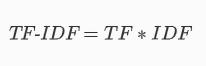

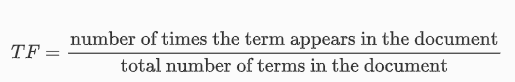

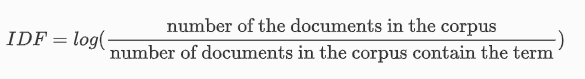

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

**Training and testing the TF-IDF bigram model**

In [ ]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_8 (Dense)             (None, 16)                320016    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 10s 16ms/step - loss: 0.4324 - accuracy: 0.8146 - val_loss: 0.3158 - val_accuracy: 0.8720
Epoch 2/10
625/625 [=====================

In [ ]:
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["I really hate this movie, this is terrible. pathetic"],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

24.29 percent positive
